# 業務要件と処理パターン (1)
## 営業成約予測　(分類）

 顧客に営業活動をしたときに、顧客が実際に商品を購入するかどうかを予測するモデル

 処理パターン　：　　分類
 
 学習　：　教師あり学習 \\
 
 データをもとに分析し, 成約確度の高い顧客を絞り込めて営業効率が上がることが目標

　「成功の見込みあり」と予測した顧客に対して実際に営業活動をした場合にせいかうするのかの比率が重要 \\
 →　**「適合率」**に該当する. 

 一方で、同じ営業成約を予測するような業務利用シーンでも**「再現率」**を併せて考慮する必要がある

 例：　営業要員が十分んいいるが、モデルで絞り込んだ顧客だけだとアプローチする対象が足りない場合 \\
 →　成約できる潜在顧客のうち、どれだけ多くの割合にアプローチできるかを意味する**再現率**をみれるようにする

 AIが使える根拠　→　正解データの入手が容易, 営業の成功率はもともと低いことが多いので成功率をあげるという点でAI効果がわかりやすい



In [2]:
# 日本語化ライブラリの導入

!pip install japanize-matplotlib | tail -n 1

# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# 乱数の種
random_seed = 123

In [3]:
# 混同行列表示用関数

def make_cm(matrix, columns):
    # matrix numpy配列
    
    # columns 項目名リスト
    n = len(columns)
    
    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n
    
    #データフレーム生成
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

*例題データ*
　
　　　公開データセット　：Bank Marketing Data Set  (銀行営業データセット）

 https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

 入力変数 : 年齢, 職業, 学歴, 債務不履行, 平均残高, 住宅ローン, 個人ローン, 連絡手段, 最終通話日, 最終通話月, 最後通話秒数, 通話回数(促進中), 前回販促後経過日数, 通話回数(販促前）, 前回販促結果

 目的変数 : 今回販促結果

 テレマーケティングしている組織の営業結果を後悔したもの

 顧客の属性（年齢や職業)と顧客に対する営業記録を入力している　　

 


In [4]:
# 公開データのダウンロードと解凍
!wget https://archive.ics.uci.edu/ml/\
machine-learning-databases/00222/bank.zip
!unzip -o bank.zip

# bank-full.csvをデータフレームに取り込み
df_all = pd.read_csv('bank-full.csv', sep=';')

# 項目名を日本語に置き換える
columns = [
    '年齢', '職業', '婚姻', '学歴', '債務不履行', '平均残高',
    '住宅ローン', '個人ローン', '連絡手段', '最終通話日',
    '最終通話月', '最終通話秒数', '通話回数_販促中',
    '前回販促後_経過日数', '通話回数_販促前', '前回販促結果',
    '今回販促結果'
]
df_all.columns = columns

--2021-01-05 03:14:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

bank.zip            100%[===================>] 565.47K  2.11MB/s    in 0.3s    

2021-01-05 03:14:18 (2.11 MB/s) - ‘bank.zip’ saved [579043/579043]

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [5]:
# データフレームの確認
display(df_all.head())

,年齢,職業,婚姻,学歴,債務不履行,平均残高,住宅ローン,個人ローン,連絡手段,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,前回販促結果,今回販促結果
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


学習データ数　:  4万5211件

営業成功した件数 5289  (出力変数 1,  失敗 0)

成功率 (11.7%)

In [6]:
# 学習データの件数と項目数の確認
print(df_all.shape)
print()

# 「今回販促結果」の値の分布確認
print(df_all['今回販促結果'].value_counts())
print()

# 営業成功率
rate = df_all['今回販促結果'].value_counts()['yes']/len(df_all)
print(f'生業成功率 : {rate:.4f}')

(45211, 17)

no     39922
yes     5289
Name: 今回販促結果, dtype: int64

生業成功率 : 0.1170


In [7]:
# 欠損値の確認
print(df_all.isnull().sum())

年齢            0
職業            0
婚姻            0
学歴            0
債務不履行         0
平均残高          0
住宅ローン         0
個人ローン         0
連絡手段          0
最終通話日         0
最終通話月         0
最終通話秒数        0
通話回数_販促中      0
前回販促後_経過日数    0
通話回数_販促前      0
前回販促結果        0
今回販促結果        0
dtype: int64


### 前処理1

 テキストのラベル値を持つ項目をOne-Hotエンコーディングする処理

In [8]:
# get_dummies関数でカテゴリ値をOne-Hotエンコーディング

# 項目をOne-Hotエンコーディングするための関数
def enc(df, column):
  df_dummy = pd.get_dummies(df[column], prefix=column)
  df = pd.concat([df.drop([column], axis=1), df_dummy], axis=1)
  return df

In [9]:
df_all2 = df_all.copy()
df_all2 = enc(df_all2, '職業')
df_all2 = enc(df_all2, '婚姻')
df_all2 = enc(df_all2, '学歴')
df_all2 = enc(df_all2, '連絡手段')
df_all2 = enc(df_all2, '前回販促結果')

#結果確認
display(df_all2.head())

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,no,2143,yes,no,5,may,261,1,-1,0,no,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,no,29,yes,no,5,may,151,1,-1,0,no,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,no,2,yes,yes,5,may,76,1,-1,0,no,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,no,1506,yes,no,5,may,92,1,-1,0,no,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,no,1,no,no,5,may,198,1,-1,0,no,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


前処理　ステップ2

 テキストのラベル値が yes / noの場合は、One-Hotエンコーディングは不要なので２値変換する

In [10]:
# yes/noを1/0に置換 

# 2値 (yes/no)の値を(1/0)に置換する関数
def enc_bin(df, column):
    df[column] = df[column].map(dict(yes=1, no=0)) 
    return df



In [11]:
df_all2 = enc_bin(df_all2, '債務不履行')
df_all2 = enc_bin(df_all2, '住宅ローン')
df_all2 = enc_bin(df_all2, '個人ローン')
df_all2 = enc_bin(df_all2, '今回販促結果')

# 結果確認
display(df_all2.head())

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,0,2143,1,0,5,may,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,may,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,may,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,may,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,may,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


### 前処理ステップ３

最終通話月　:　本来はOne-Hotエンコードするものだが12項目と思われる

月の間の連続性は、12月と1月の間が不連続になることを除けば１項目の数値で表現できる

In [12]:
# 月名(jn, feb, ...)を1, 2, ...に置換
month_dict = dict(jan=1, feb=2, mar=3, apr=4,
                  may=5, jun=6, jul=7, aug=8, sep=9,
                  oct=10, nov=11, dec=12)

def enc_month(df, column):
  df[column] = df[column].map(month_dict)
  return df



In [13]:
df_all2 = enc_month(df_all2, '最終通話月')

#結果確認
display(df_all2.head())

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,0,2143,1,0,5,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [14]:
# 入力データと正解データの分割
x = df_all2.drop('今回販促結果', axis=1)
y = df_all2['今回販促結果'].values

# 訓練データと検証データの分割
# 訓練データ６０%　検証データ40％の比率で分割する
test_size = 0.4

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=random_seed,
    stratify=y)

In [15]:
# 候補アルゴリズムのリスト化

# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
algorithm1 = LogisticRegression(random_state=random_seed)

#　決定木
from sklearn.tree import DecisionTreeClassifier
algorithm2 = DecisionTreeClassifier(random_state=random_seed)

# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
algorithm3 = RandomForestClassifier(random_state=random_seed)

# XGBoost
from xgboost import XGBClassifier
algorithm4 = XGBClassifier(random_state=random_seed)

algorithms = [algorithm1, algorithm2, algorithm3, algorithm4]

今回　サポートベクターマシン(SVM）は確率値の関数（predict_proba)が使えないので除外

In [16]:
# 交差検定法を用いて最適なアルゴリズムの選択
from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

from sklearn.model_selection import cross_val_score
for algorithm in algorithms:
  #交差検定法の実行
  scores = cross_val_score(algorithm, x_train, y_train, cv=stratifiedkfold, scoring='roc_auc')
  score = scores.mean()
  name = algorithm.__class__.__name__
  print(f'平均スコア : {score:.4f} 個別スコア : {scores} {name}')

平均スコア : 0.8325 個別スコア : [0.8275 0.8287 0.8412] LogisticRegression
平均スコア : 0.6958 個別スコア : [0.6917 0.7023 0.6935] DecisionTreeClassifier
平均スコア : 0.9200 個別スコア : [0.9259 0.9196 0.9145] RandomForestClassifier
平均スコア : 0.9222 個別スコア : [0.9246 0.9213 0.9206] XGBClassifier


scoring ='roc_aut'　

どの計算方法で順位をつけるかを指定するパラメータで、defaultはaccuracy (精度）

今回は、正解データ1と0の比率がアンバランスであるので、精度だけ見ても良いアルゴリズムが見つかる可能性が低いため, ROC AUC値(ROC曲線下の面積）を利用する



#### 学習・予測・評価

In [17]:
#アルゴリズム選択
# 前の結果よりXGBoostを採用
algorithm = XGBClassifier(random_state=random_seed)

# 学習
algorithm.fit(x_train, y_train)

#　予想
y_pred = algorithm.predict(x_test)

In [18]:
#　評価

# 混同行列を出力
from sklearn.metrics import confusion_matrix
df_matrix = make_cm(confusion_matrix(y_test, y_pred), ['失敗', '成功'])
display(df_matrix)

# 適合率, 再現率, F値を計算
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'適合率: {precision:.4f} 再現率 : {recall:.4f} F値 : { fscore:.4f}')


予測結果     
             失敗   成功
正解データ 失敗  15593  376
      成功   1341  775

適合率: 0.6733 再現率 : 0.3663 F値 : 0.4744


ランダムにアプローチした場合 11.7%しかなかった営業成功率が適合率67.33%になったので成功率が６倍になったことを意味する

次にモデルのチューニングについて考えてみる

今回のモデルで抽出した見込み顧客は合計で1151人(=376+775)であった

営業担当者がたくさんいて、　もっと多くの顧客に営業できる状況だった場合、もう少し判断基準を甘くして、より多くの候補をあげたくなることがある

#### チューニング

　通常の機械学習モデルのチューニング : アルゴリズムやパラメータの値を調整してモデルそのものを作り直す

　今回のモデルチューニング : モデル自体は買えずにモデルの「閾値」を調整してユーザが望む結果に近づけるアプローチ

　基本的には, 閾値は 0.5に設定しているので判断基準をどう帰るかを考える

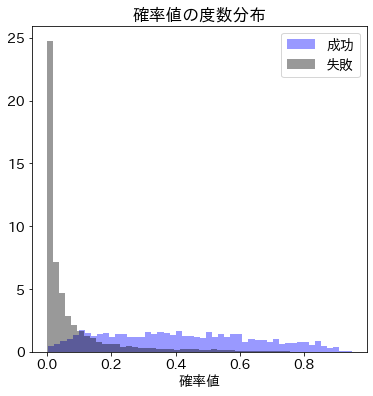

In [19]:
# 確率値の度数分布グラフ
import seaborn as sns

# y=0の確率値取得
y_proba0 = algorithm.predict_proba(x_test)[:, 1]

# y_test=0とy_test1でデータ分割
y0 = y_proba0[y_test==0]
y1 = y_proba0[y_test==1]

# 散布図描画
plt.figure(figsize=(6,6))
plt.title('確率値の度数分布')
sns.distplot(y1, kde=False, norm_hist=True,
             bins=50, color='b', label='成功')
sns.distplot(y0, kde=False, norm_hist=True,
             bins=50, color='k', label='失敗')
plt.xlabel('確率値')
plt.legend()
plt.show()

#### これからやること

閾値 0.5 (defult)　で分類していた。

その値を少し下げたとしても成功位rつは悪くならず、切り捨てられる成功ケースが減ると予想される

このためには、閾値をパラメータにした形で予測することが必要である

In [20]:
# 閾値を変更した場合の予測関数の定義
def pred(algorithm, x, thres):
  #確率値の取得 (行列)
  y_proba = algorithm.predict_proba(x)

  #予測結果１の確率値
  y_proba1 = y_proba[:,1]

  #　予測結果１の確率値 > 閾値
  y_pred = (y_proba1 > thres).astype(int)
  return y_pred
  

In [21]:
# 閾値を0.05刻みに変化させて、適合率, 再現率, F値を計算する
thres_list = np.arange(0.5, 0, -0.05)

for thres in thres_list:
  y_pred = pred(algorithm, x_test, thres)
  pred_sum = y_pred.sum()
  precision, recall, fscore, _ = precision_recall_fscore_support(
      y_test, y_pred, average='binary')
  print(f'閾値: {thres:.2f} 陽性予測数 : {pred_sum}\
  適合率　： {precision:.4f} 再現率 : {recall:.4f} F値 : {fscore:.4f})')

閾値: 0.50 陽性予測数 : 1151  適合率　： 0.6733 再現率 : 0.3663 F値 : 0.4744)
閾値: 0.45 陽性予測数 : 1412  適合率　： 0.6402 再現率 : 0.4272 F値 : 0.5125)
閾値: 0.40 陽性予測数 : 1724  適合率　： 0.6108 再現率 : 0.4976 F値 : 0.5484)
閾値: 0.35 陽性予測数 : 2053  適合率　： 0.5889 再現率 : 0.5714 F値 : 0.5800)
閾値: 0.30 陽性予測数 : 2411  適合率　： 0.5649 再現率 : 0.6437 F値 : 0.6017)
閾値: 0.25 陽性予測数 : 2823  適合率　： 0.5257 再現率 : 0.7013 F値 : 0.6009)
閾値: 0.20 陽性予測数 : 3364  適合率　： 0.4822 再現率 : 0.7665 F値 : 0.5920)
閾値: 0.15 陽性予測数 : 4081  適合率　： 0.4347 再現率 : 0.8384 F値 : 0.5725)
閾値: 0.10 陽性予測数 : 5260  適合率　： 0.3675 再現率 : 0.9135 F値 : 0.5241)
閾値: 0.05 陽性予測数 : 7523  適合率　： 0.2741 再現率 : 0.9745 F値 : 0.4278)


適合率と再現率はトレードオフの関係になっているので, バランスをみるF値の良い値を使う

今回の閾値は 0.3とした場合が良さそうである

In [22]:
#F値を最大にする閾値は0.30
y_final = pred(algorithm, x_test, 0.30)

# 混同行列を出力
df_matrix2 = make_cm(
    confusion_matrix(y_test, y_final), ['失敗', '成功'])
display(df_matrix2)

# 適合率, 再現率, F値を計算
precision, recall, fscore, _= precision_recall_fscore_support(
    y_test, y_final, average='binary')
print(f' 適合率　： {precision:.4f} 再現率 : {recall:.4f} F値 : {fscore:.4f})')

予測結果      
             失敗    成功
正解データ 失敗  14920  1049
      成功    754  1362

 適合率　： 0.5649 再現率 : 0.6437 F値 : 0.6017)


### 重要度分析

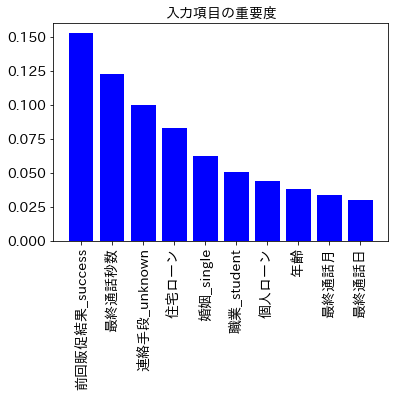

In [23]:
# 重要度ベクトルの取得
importances = algorithm.feature_importances_

# 項目名をキーにSeriesを生成
w = pd.Series(importances, index=x.columns)

# 値の大きい順にソート
u = w.sort_values(ascending=False)

# トップ10のみ抽出
v = u[:10]

#重要度の棒グラフ表示
plt.title('入力項目の重要度', fontsize=14)
plt.bar(range(len(v)), v, color='b', align='center')
plt.xticks(range(len(v)), v.index, rotation=90, fontsize=14)
plt.show()

各項目の影響度が目的変数に対して、良い方向に作用するのか、悪い方向に作用するのかは不明

上位3項目に関して、個別にヒストグラムを表示する

**課題：　上位4〜１０もヒストグラムを作り、どう影響するのかを予測せよ**

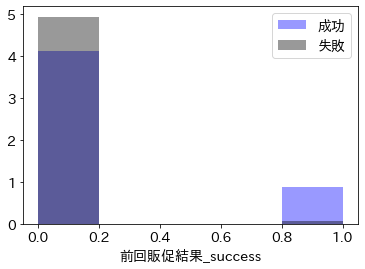

In [24]:
column = '前回販促結果_success'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=5, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=5, color='k', label='失敗')

plt.legend()
plt.show()

右側のグラフをみる

上部が青色なら良い方向の灰色なら悪い方向の影響となる

今回は、良い方向に影響がある。　前回の販促で成功した顧客は良い方向の営業がある

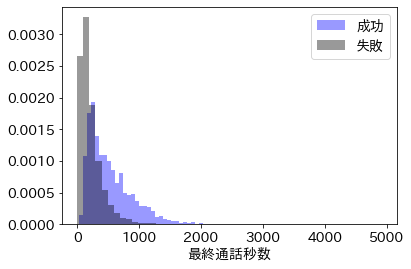

In [25]:
column = '最終通話秒数'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=50, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=50, color='k', label='失敗')

plt.legend()
plt.show()

長く通話している顧客ほど成功の可能性が高いことがわかる

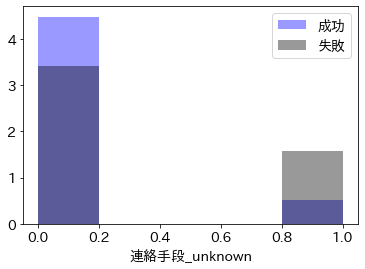

In [27]:
column = '連絡手段_unknown'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=5, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=5, color='k', label='失敗')

plt.legend()
plt.show()

悪い方向に影響があることがわかる

**課題を以下に解く**

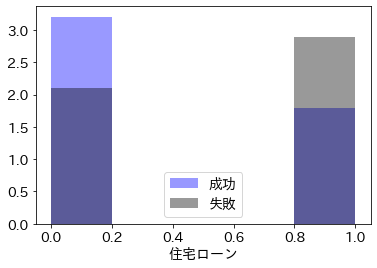

In [28]:
column = '住宅ローン'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=5, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=5, color='k', label='失敗')

plt.legend()
plt.show()

住宅ローンがない場合の方が成功率が上がるので負の方向に作用する

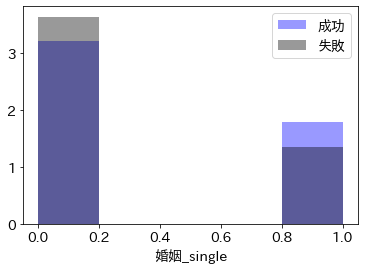

In [29]:
column = '婚姻_single'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=5, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=5, color='k', label='失敗')

plt.legend()
plt.show()

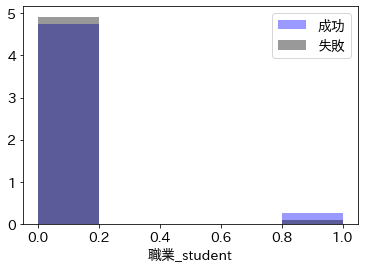

In [30]:
column = '職業_student'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=5, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=5, color='k', label='失敗')

plt.legend()
plt.show()

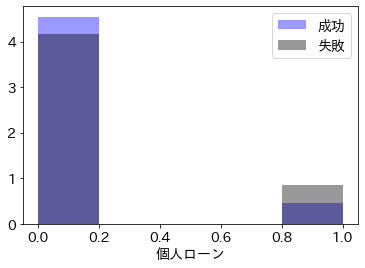

In [31]:
column = '個人ローン'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=5, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=5, color='k', label='失敗')

plt.legend()
plt.show()

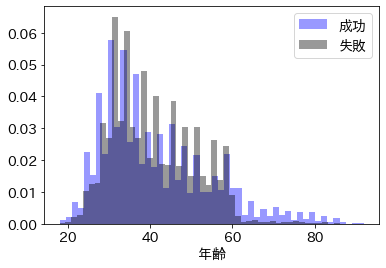

In [35]:
column = '年齢'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=50
             , color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=50, color='k', label='失敗')

plt.legend()
plt.show()

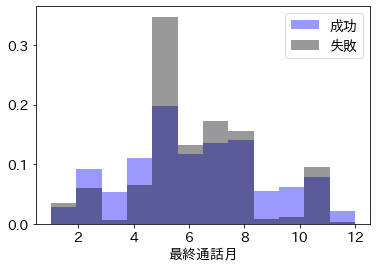

In [37]:
column = '最終通話月'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=12, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=12, color='k', label='失敗')

plt.legend()
plt.show()

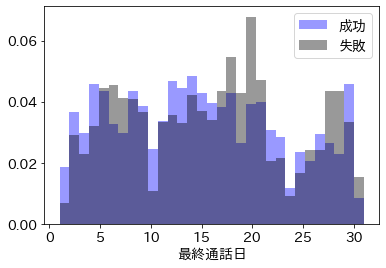

In [38]:
column = '最終通話日'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True,
             bins=31, color='b', label='成功')
sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True,
             bins=31, color='k', label='失敗')

plt.legend()
plt.show()